### Preprocess cell adata

#### Koenig et al. 2022 (Lavine Lab)

1. Technology: 10x 5ʹ v1.1
2. Cell vs. nuclei: Nuclei
3. Region: LV (apical anterior wall)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import gc
import scanpy.external as sce

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

In [3]:
%%time
# load entire dataset
adata = sc.read_h5ad("03_processed_all_Koenig.h5ad")

CPU times: user 1.1 s, sys: 8.16 s, total: 9.27 s
Wall time: 12.6 s


In [4]:
Counter(adata.obs.cell_or_nuclei)

Counter({'Nuclei': 220752, 'Cell': 43821})

In [5]:
# filter to only cells
adata = adata[adata.obs.cell_or_nuclei == "Cell", :].copy()
adata

AnnData object with n_obs × n_vars = 43821 × 45068
    obs: 'sex', 'cell_type', 'donor_id', 'age', 'disease', 'cell_or_nuclei', 'study', 'technology', 'region', 'consistent_cell_type'
    layers: 'counts'

In [6]:
# check that these are the raw counts (the sum of all values in the sparse matrix should be an integer value)
adata.X.sum(axis = 1)

matrix([[4998],
        [6029],
        [2486],
        ...,
        [5155],
        [3702],
        [3296]])

In [7]:
# remove donors without age information (TWCM-11-3)
adata = adata[~adata.obs.age.isnull(),:]
adata.obs['age'] = adata.obs.age.astype(int)

/mnt/data1/william/tmp/ipykernel_367736/2753006719.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['age'] = adata.obs.age.astype(int)


In [8]:
# check that adata.var are the gene symbols 
adata.var_names

Index(['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'RP11-34P13.14', 'RP11-34P13.9', 'FO538757.3', 'FO538757.2',
       'AP006222.2',
       ...
       'AP001468.1', 'AP001469.1', 'AP001469.2', 'AP001469.3', 'AC136352.3',
       'AC136352.2', 'AC171558.3', 'BX004987.1', 'AC145212.1', 'MAFIP'],
      dtype='object', length=45068)

### Use 15% thresholds for mitochondrial, ribosomal, and hemoglobin rather than 5%

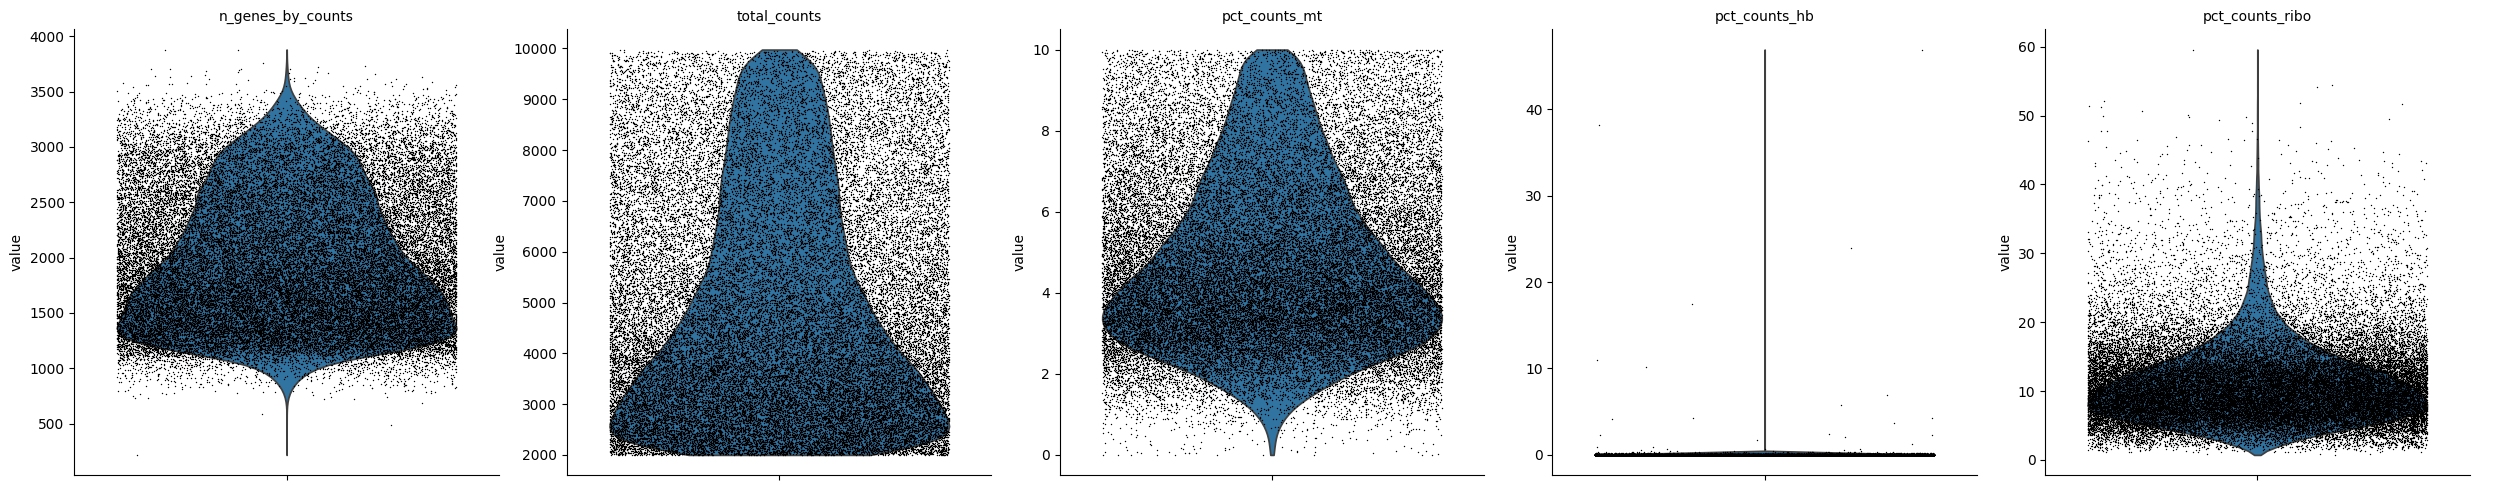

Filtered out 8649 cells
CPU times: user 23.3 s, sys: 30.9 s, total: 54.2 s
Wall time: 7.93 s


In [9]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 15.0
ribo_threshold = 15.0
hb_threshold = 15.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [10]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 156 likely doublets
CPU times: user 4min 38s, sys: 2min 28s, total: 7min 6s
Wall time: 3min 16s


2024-12-18 13:13:48,040 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-18 13:13:51,889 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-18 13:13:52,026 - harmonypy - INFO - Iteration 1 of 10
2024-12-18 13:13:59,513 - harmonypy - INFO - Iteration 2 of 10
2024-12-18 13:14:08,923 - harmonypy - INFO - Iteration 3 of 10
2024-12-18 13:14:18,693 - harmonypy - INFO - Iteration 4 of 10
2024-12-18 13:14:27,817 - harmonypy - INFO - Iteration 5 of 10
2024-12-18 13:14:35,691 - harmonypy - INFO - Converged after 5 iterations


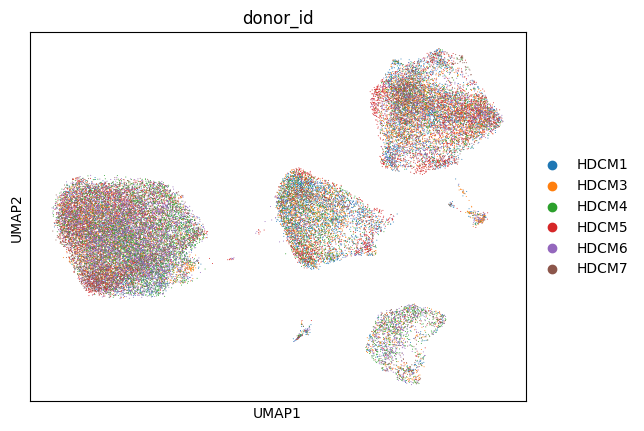

CPU times: user 12min 6s, sys: 48min 18s, total: 1h 25s
Wall time: 1min 29s


In [11]:
%%time
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

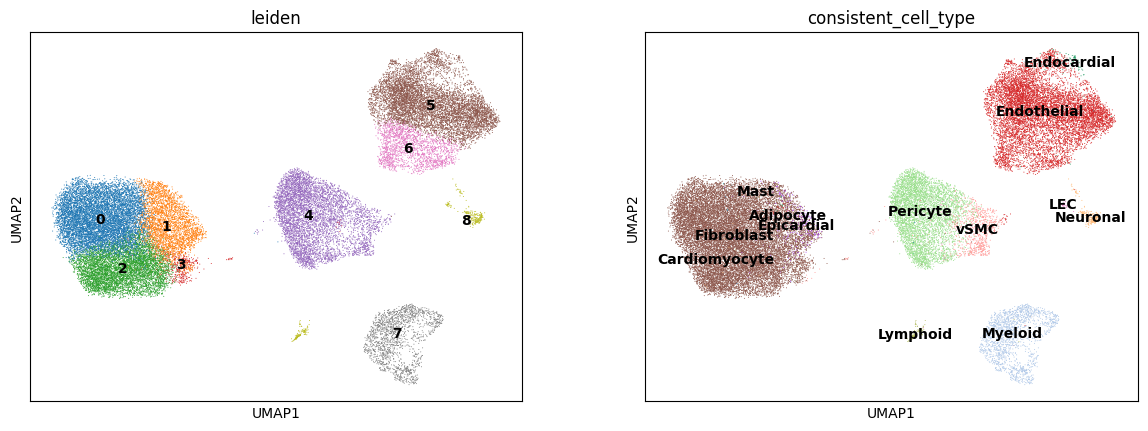

In [12]:
sc.pl.umap(adata, color=["leiden", "consistent_cell_type"], size=2, legend_loc = "on data")

In [13]:
set(adata.obs.consistent_cell_type)

{'Adipocyte',
 'Cardiomyocyte',
 'Endocardial',
 'Endothelial',
 'Epicardial',
 'Fibroblast',
 'LEC',
 'Lymphoid',
 'Mast',
 'Myeloid',
 'Neuronal',
 'Pericyte',
 'vSMC'}

In [14]:
adata.write("processed_Koenig_cell.h5ad")